# Dominant Balance analysis of optical wave breaking dynamics in the NLSE 
###### Andrei V. Ermolaev for the PhD thesis "Data-driven methods for analysing nonlinear propagation in optical fibers" , july 2024
This code is based on the following works:<br>
J. L. Callaham, J. V. Koch, B. W. Brunton, J. N. Kutz, and S. L. Brunton, “Learning dominant physical processes with data-driven balance models,” Nature Communications, vol. 12, no. 1, p. 1016, 2021.<br>
B. E. Kaiser, J. A. Saenz, M. Sonnewald, and D. Livescu, “Automated identification of dominant physical processes,” Engineering Applications of Artificial Intelligence, vol. 116, p. 105496, 2022.<br>
<br>
Some parts of the code are taken directly from: <br>
J. L. Callaham, J. V. Koch, B. W. Brunton, J. N. Kutz, and S. L. Brunton, “Learning Dominant Physical Processes With Data-driven Balance Models. Methods and Codes. Release accompanying publication.,” https://doi.org/10.5281/zenodo.4428904, 2021.

### Optical wave breaking example
See chapter 4, section 4.2.3 in Ref. [G. P. Agrawal, Nonlinear Fiber Optics. Elsevier Science & Technology, 2019]

$$
\begin{array}{l}
\text{Normalised form of the NLSE:}\,\,\,\,
i\dfrac{\partial u}{\partial x} - \dfrac{d}{2}\dfrac{\partial^{2} u}{\partial t^{2}} + |u|^2 u = 0 \,\,\,\,\,\,\,\, \\
\text{Initial conditions:}\,\,\,\,
u(0,t) = N \exp(-t^{2}) \,\,\,\,
\text{with} \,\,\,\,
N = T_{0}\sqrt{\gamma P_{0}|\beta_{2}|} = 30
\end{array}
$$

### Code Structure Outline

#### I. Dimensional code to simulate optical wave breaking dynamics via split-step Fourier method

#### II. Dominant balance analysis of the spatio-spectral dynamics

#### III. Dominant balance analysis of the spatio-temporal dynamics

##### For both spatio-temporal and spatio-spectral dynamics we provide:
- Piece of code to estimate the differential equation terms
- Module to perform the GMM cluster analysis in the corresponding equation space
- Clusterwise hypothesis selection procedure via combinatorial model selection algorithm
- Other pieces of code to display the results

## I Numerical simulation of the field propagation

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import scipy.io as sio
import findiff as fd
import cmath as cmt
from IPython import display
from sklearn.mixture import GaussianMixture

#Display settings
import matplotlib as mpl
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)

### 1 Split-step Fourier method dimensional code to simulate OWB propagation

Dispersion length = 0.16244999999999998
Nonlinear length = 0.00018037518037518038


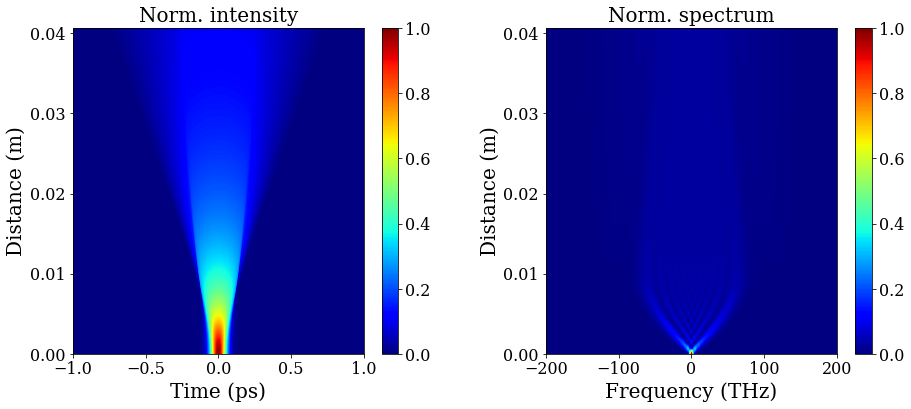

In [30]:
# Fibre Parameters
beta2 = 20e-27
gamma = 2.1e-3

# Input pulse parameters
T0 = 57e-15
P0 = 2.64 * 10**(6)
lambda0 = 850e-9
c = 299792458
F0 = c / lambda0

# Time and frequency Grids
Npts = 2 * 2048
Tmax = 1e-12
dT = 2 * Tmax / (Npts - 1)
TT = np.arange(-Npts / 2, Npts / 2) * dT
FF = np.arange(-Npts / 2, Npts / 2) / (2 * Tmax)
WW = 2 * np.pi * FF
lambda_val = c / (FF + F0)

# Characteristic Length Scales
L_D = T0**2 / abs(beta2)
L_NL = 1 / (gamma * P0)
print('Dispersion length =', L_D)
print('Nonlinear length =', L_NL)

# Gaussian input pulse (initial conditions)
A0 = np.sqrt(P0) * np.exp(-TT**2 / (2 * T0**2))

# ----------------------- Propagation --------------------------
# Spatial grid
Nz = 3000
Lz = 0.25 * L_D
dz = Lz / Nz
Nplots = 1000

# Operators
sel = round(Nz / (Nplots - 1))
ZZ = np.linspace(0, Lz, Nplots)
Ip = np.zeros((Nplots, Npts))
Ip_TF = np.zeros((Nplots, Npts))
AAt = np.zeros((Nplots, Npts), dtype = 'complex')
AAf = np.zeros((Nplots, Npts), dtype = 'complex')

# Input field
Ip[0, :] = np.abs(A0)**2
Ip_TF[0, :] = np.abs(np.fft.fftshift(np.fft.ifft(np.fft.fftshift(A0))))**2
S_norm = np.max(Ip_TF[0, :])
I_norm = np.max(Ip[0, :])
Ip_TF[0, :] = Ip_TF[0, :] / S_norm
AAt[0, :] = A0
AAf[0, :] = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(A0)))

A1 = A0
for ii in range(1, Nz):
    A_TF = np.fft.fftshift(np.fft.ifft(A1)) * np.exp(1j * beta2 / 2 * WW**2 * dz)
    A1 = np.fft.fft(np.fft.fftshift(A_TF))
    A1 = A1 * np.exp(1j * gamma * dz * np.abs(A1)**2)

    if (ii / sel) == round(ii / sel):
        Ip[ii // sel, :] = np.abs(A1)**2
        Ip_TF[ii // sel, :] = np.abs(A_TF)**2 / S_norm
        
        AAt[ii // sel, :] = A1 
        AAf[ii // sel, :] = A_TF
        
        # ----------------------- Display --------------------------
        # ----------------------- uncomment if needed --------------------------
#         display.clear_output(wait = True)
#         plt.figure(figsize=(15, 4));
#         plt.subplot(121)
#         plt.plot(TT * 10**12, np.abs(AAt[ii // sel, :])**2 / I_norm, color = 'darkblue')
#         plt.ylim(-0.02,1)
#         plt.xlim(-1, 1)
#         plt.xlabel('T, ps')
#         plt.ylabel('Norm. intensity')
#         plt.grid('True',linestyle = ':')
        
#         plt.subplot(122)
#         plt.plot(FF * 1e-12, np.abs(AAf[ii // sel, :])**2 / S_norm, color = 'darkred')
#         plt.ylim(-0.02, 1)
#         plt.xlim(-200, 200)
#         plt.xlabel('Frequency (THz)')
#         plt.ylabel('Norm. spectrum')
#         plt.grid('True',linestyle = ':')
#         plt.suptitle(f'z = {ii * dz:.5f} m', fontsize = 20)
#         plt.subplots_adjust(wspace=0.4)
#         plt.show()

        # ----------------------- Display - linear scale --------------------------

plt.figure(figsize=(15, 6))
plt.subplot(121)
b = plt.pcolormesh(1e12 * TT, ZZ, np.abs(AAt)**2 / I_norm, shading='auto', cmap='jet')
plt.xlabel('Time (ps)')
plt.ylabel('Distance (m)')
plt.xlim([-1, 1])
cbar = plt.colorbar(b)
plt.title('Norm. intensity')
plt.yticks([0, 0.01, 0.02, 0.03, 0.04])

plt.subplot(122)
a = plt.pcolormesh(1e-12 * FF, ZZ, np.abs(AAf)**2 / S_norm, shading='auto', cmap='jet')
plt.xlabel('Frequency (THz)')
plt.ylabel('Distance (m)')
plt.xlim([-200, 200])
plt.title('Norm. spectrum')
cbar = plt.colorbar(a)
plt.subplots_adjust(wspace=0.3)
plt.yticks([0, 0.01, 0.02, 0.03, 0.04])
plt.show()

### 2. Data preprocessing

### 2.1 Converting to dimensionless form

In [31]:
t = TT / T0
x = ZZ * gamma * P0
u = AAt / np.sqrt(P0)
s = (AAf / np.sqrt(S_norm))
f = np.arange(-Npts / 2, Npts / 2) / (2 * max(t))
d = beta2 / (T0**2 * gamma * P0)

### 2.2 Estimating individual terms, verifying the balance in equation in temporal domain

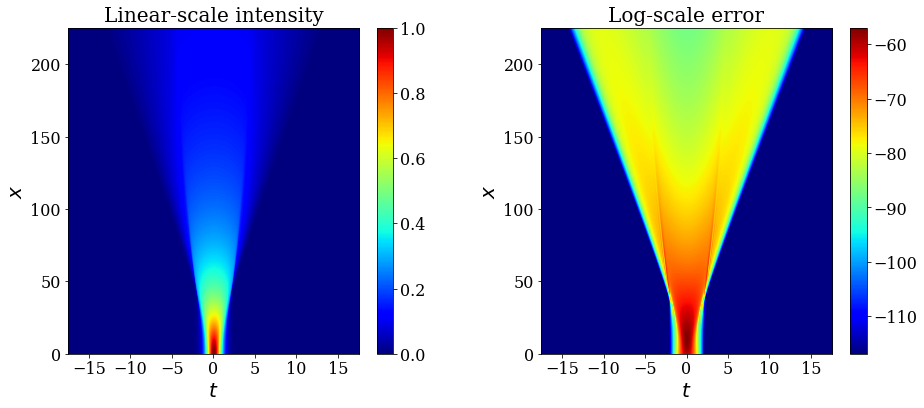

Error order =  1.1830826029177854e-05


In [32]:
# Derivative estimation via FinDiff
dt = t[1] - t[0]
dx = x[1] - x[0]
n = len(t)
ACC = 8

#Computing the terms in the equation
d_dx = fd.FinDiff(0, dx, 1, acc = ACC)
ux = 1j * d_dx(u)
d2_dt2 = fd.FinDiff(1, dt, 2, acc = ACC)
utt = -d/2 * d2_dt2(u)
uuu = u * np.abs(u)**2

plt.figure(figsize=(15, 6))
it = lambda field: abs(field)**2 # Mod. squared of the field
colc ='jet'
## Plotting the temporal domain evolution
lIT = it(u); # log scale temporal intensity
mlIT = max(lIT.flatten())     # max value, for scaling plot

plt.subplot(1,2,1)
plt.imshow(lIT, cmap=colc, origin='lower', vmin=0, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto')          # plot as pseudocolor map
plt.title('Linear-scale intensity')
cb = plt.colorbar()
plt.xticks([-15,-10,-5,0,5,10,15])
plt.xlabel('$t$')
plt.ylabel('$x$')


#Plotting the temporal domain error
it = lambda field: 10*np.log10(abs(field)**2) # Log-scaled error
lIT = it(ux + utt + uuu)  # log-scale sum of the terms
mlIT = max(lIT.flatten()) # max value, for scaling plot

plt.subplot(1,2,2)
plt.imshow(lIT, cmap=colc, origin='lower', vmin=mlIT-60, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto')          # plot as pseudocolor map
plt.xlabel('Delay')
plt.ylabel('Distance')
plt.title('Log-scale error')
cb = plt.colorbar()
plt.xticks([-15,-10,-5,0,5,10,15])
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.subplots_adjust(wspace=0.3)
plt.show()

# Total abs sum of the terms across the space normalised to the field
print('Error order = ', (np.sum(np.abs(ux + utt + uuu)))**(1/3) / np.sum(np.abs(u)))

### 2.3 Estimating individual terms in spectral domain using the Fourier transform

In [33]:
U = np.empty_like(u)
Ux = np.empty_like(ux)
Utt = np.empty_like(utt)
UUU = np.empty_like(uuu)
for ii in range(0, len(x), 1):
    U[ii,:] = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(u[ii,:])))
    Ux[ii,:] = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(ux[ii,:])))
    Utt[ii,:] = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(utt[ii,:])))
    UUU[ii,:] = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(uuu[ii,:])))

### 3.1 Plotting the individual contributions (log-scaled) of all the terms and error across the spatio-temporal domain

c:\users\ermol\pysindy-master\examples\venv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


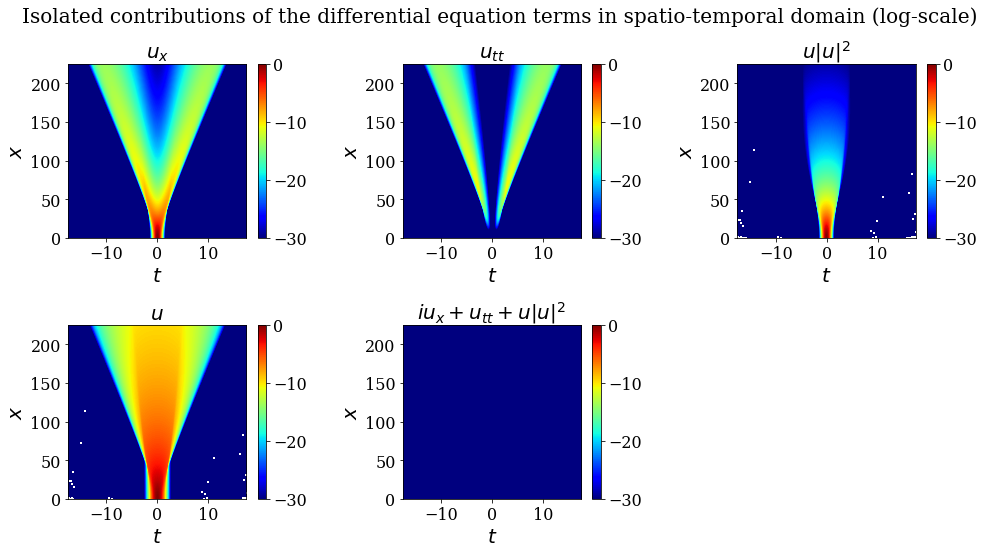

In [34]:
it = lambda field: 10*np.log10(abs(field)**2) # Log-scaled field
TRS = 30 # threshold to get rid of low intensity regions

plt.figure(figsize=(16, 8));
plt.subplot(2, 3, 4)
# Plot full field intensity
C = it(u);
mlIT = max(C.flatten())
plt.imshow(C, cmap=colc, origin='lower', vmin=mlIT-TRS, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto');          # plot as pseudocolor map
plt.xlabel('$t$')
plt.ylabel('$x$');
plt.colorbar()
plt.title('$u$')

plt.subplot(2, 3, 1);
# LHS
C = it(ux);
plt.imshow(C, cmap=colc, origin='lower', vmin=mlIT-TRS, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto');          # plot as pseudocolor map
plt.xlabel('$t$')
plt.ylabel('$x$');
plt.colorbar()
plt.title('$u_x$')

plt.subplot(2, 3, 2);
C = it( utt );
plt.imshow(C, cmap=colc, origin='lower', vmin=mlIT-TRS, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto');          # plot as pseudocolor map
plt.xlabel('$t$')
plt.ylabel('$x$');
plt.colorbar()
plt.title('$u_{tt}$')

plt.subplot(2, 3, 3);
C = it( uuu );
plt.imshow(C, cmap=colc, origin='lower', vmin=mlIT-TRS, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto');          # plot as pseudocolor map
plt.xlabel('$t$')
plt.ylabel('$x$');
plt.colorbar()
plt.title('$u|u|^2$')

plt.subplot(2, 3, 5);
C = it(+ux + utt + uuu);
plt.imshow(C, cmap=colc, origin='lower', vmin=mlIT-TRS, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto');          # plot as pseudocolor map
plt.xlabel('$t$')
plt.ylabel('$x$');
plt.colorbar()
plt.title('$iu_{x} + u_{tt} + u|u|^2$')
plt.suptitle('Isolated contributions of the differential equation terms in spatio-temporal domain (log-scale)', fontsize = 20)


plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
plt.show()

### 3.2 Plotting the individual contributions (log-scaled) of all the terms and error across the spatio-spectral domain

c:\users\ermol\pysindy-master\examples\venv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


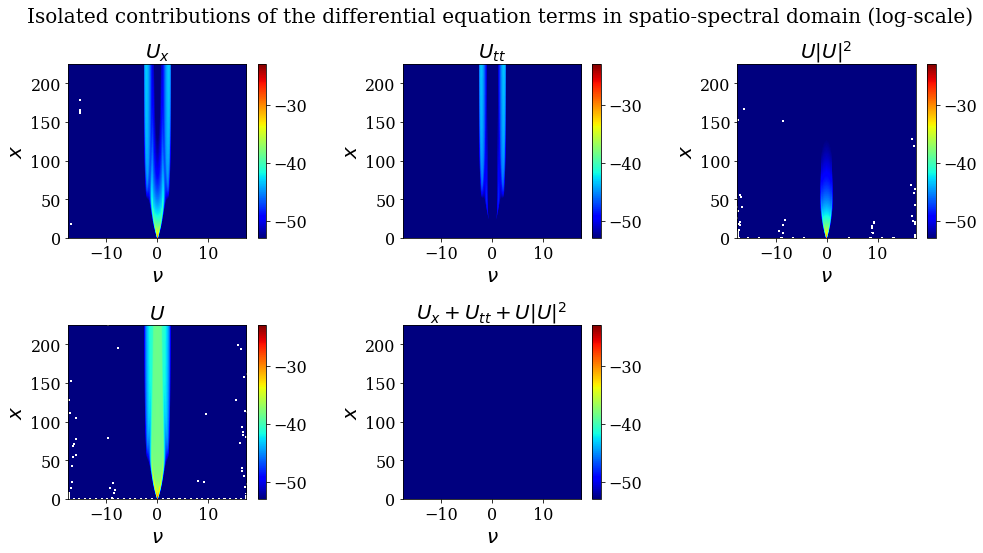

In [35]:
it = lambda field: 10*np.log10(abs(field)**2) # Log-scaled field
TRS = 30 # threshold to get rid of low intensity regions

plt.figure(figsize=(16, 8));
plt.subplot(2, 3, 4)
C = it(U);
mlIT = max(C.flatten())
plt.imshow(C, cmap=colc, origin='lower', vmin=mlIT-TRS, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto');          # plot as pseudocolor map
plt.xlabel('$\\nu$')
plt.ylabel('$x$');
plt.colorbar()
plt.title('$U$')

plt.subplot(2, 3, 1);
# LHS
C = it(Ux);
plt.imshow(C, cmap=colc, origin='lower', vmin=mlIT-TRS, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto');          # plot as pseudocolor map
plt.xlabel('$\\nu$')
plt.ylabel('$x$');
plt.colorbar()
plt.title('$U_x$')

plt.subplot(2, 3, 2);
C = it( Utt );
plt.imshow(C, cmap=colc, origin='lower', vmin=mlIT-TRS, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto');          # plot as pseudocolor map
plt.xlabel('$\\nu$')
plt.ylabel('$x$');
plt.colorbar()
plt.title('$U_{tt}$')

plt.subplot(2, 3, 3);
C = it( UUU );
plt.imshow(C, cmap=colc, origin='lower', vmin=mlIT-TRS, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto');          # plot as pseudocolor map
plt.xlabel('$\\nu$')
plt.ylabel('$x$');
plt.colorbar()
plt.title('$U|U|^2$')

plt.subplot(2, 3, 5);
C = it(+Ux + Utt + UUU);
plt.imshow(C, cmap=colc, origin='lower', vmin=mlIT-TRS, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto');          # plot as pseudocolor map
plt.xlabel('$\\nu$')
plt.ylabel('$x$');
plt.colorbar()
plt.title('$U_{x} + U_{tt} + U|U|^2$')
plt.suptitle('Isolated contributions of the differential equation terms in spatio-spectral domain (log-scale)', fontsize = 20)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
plt.show()

Please note that the notation $U_{x}, U_{tt}$ and $U|U|^{2}$ used here stands for the Fourier transformed NLSE terms $iu_{x}, u_{tt}$ and $u|u|^{2}$

# II Dominant balance analysis in spatio-spectral domain

### 1. Constructing the equation space matrix

In [36]:
nfeatures = 3 # features (number of differential equation terms)
featuremap = np.zeros([len(x), len(t), nfeatures], dtype='complex64');

featuremap[:, :, -3] = Ux
featuremap[:, :, -2] = Utt
featuremap[:, :, -1] = UUU

labels = ['$U_{x}$', '$U_{tt}$', '$U|U|^2$']

# Downsample for building model (optional, default - no downsampling)
shift_x, shift_t = 1, 1
tmin = 0
x0 = np.arange(0, len(x), shift_x)
t0 = np.arange(tmin, len(t), shift_t)
featuremap = featuremap[x0, :, :]
featuremap = featuremap[:, t0, :]

# Treshold near-zero intensity values
lIT = it(U)
lIT = lIT[x0, :]
lIT = lIT[:, t0]
mlIT = max(lIT.flatten())
mask = lIT > mlIT - TRS

features = np.reshape(featuremap, [len(x0)*len(t0), nfeatures], order='F')
features = features[mask.flatten('F'), :]
features = np.hstack((np.real(features), np.imag(features)))

c:\users\ermol\pysindy-master\examples\venv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [37]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(features)
features = scaler.transform(features)

### 2. Visualising the dynamical patterns in equation space 

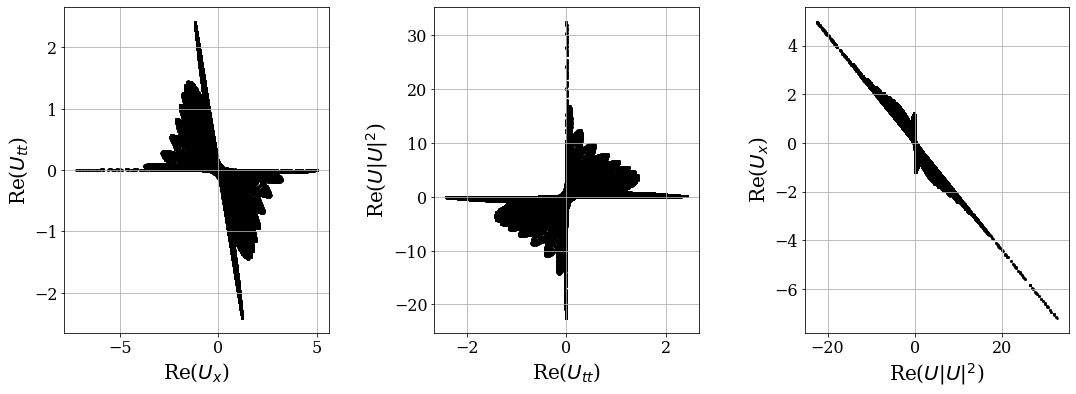

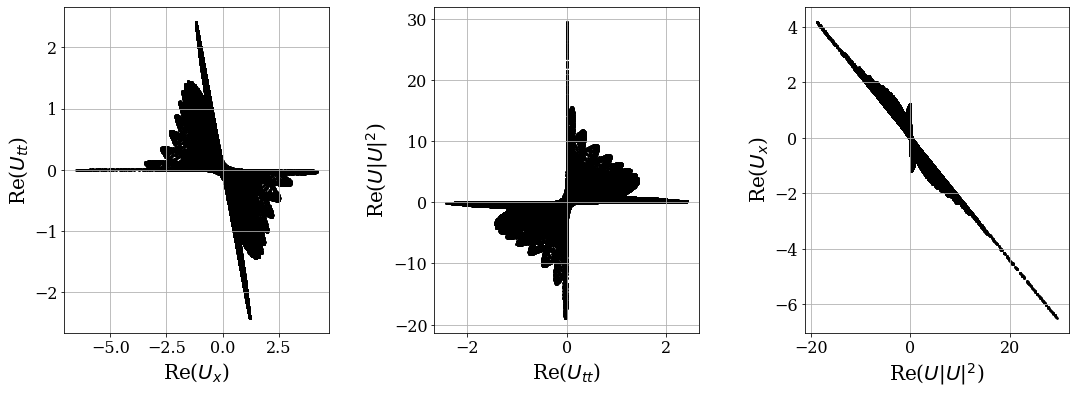

In [38]:
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.scatter(features[:, 0], features[:, 1], 3, 'k')
plt.xlabel(f'Re({labels[0]})')
plt.ylabel(f'Re({labels[1]})')
plt.grid()

plt.subplot(132)
plt.scatter(features[:, 1], features[:, 2], 3, 'k')
plt.xlabel(f'Re({labels[1]})')
plt.ylabel(f'Re({labels[2]})')
plt.grid()

plt.subplot(133)
plt.scatter(features[:, 2], features[:, 0], 3, 'k')
plt.xlabel(f'Re({labels[2]})')
plt.ylabel(f'Re({labels[0]})')
plt.grid()

plt.subplots_adjust(wspace=0.4)  # Adjust the space between plots
plt.show()

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.scatter(features[:, 3], features[:, 4], 3, 'k')
plt.xlabel(f'Re({labels[0]})')
plt.ylabel(f'Re({labels[1]})')
plt.grid()

plt.subplot(132)
plt.scatter(features[:, 4], features[:, 5], 3, 'k')
plt.xlabel(f'Re({labels[1]})')
plt.ylabel(f'Re({labels[2]})')
plt.grid()

plt.subplot(133)
plt.scatter(features[:, 5], features[:, 3], 3, 'k')
plt.xlabel(f'Re({labels[2]})')
plt.ylabel(f'Re({labels[0]})')
plt.grid()

plt.subplots_adjust(wspace=0.4)
plt.show()

### 3. Performing the GMM 

In [39]:
# Note that a sufficiently large number of GMM clusters are chosen here to illustrate 
# how the algorithm is adapted for the case of redundant clusters
# training GMM model may take some time
nc = 8
seed = 977799
model = GaussianMixture(n_components=nc, random_state=seed)
model.fit(features)

GaussianMixture(n_components=8, random_state=977799)

### 4. Recomputing for the full domain (if needed) 

In [40]:
nfeatures = 3 # features (number of differential equation terms)
featuremap = np.zeros([len(x), len(t), nfeatures], dtype='complex64');

featuremap[:, :, -3] = Ux
featuremap[:, :, -2] = Utt
featuremap[:, :, -1] = UUU

tmin = 0
t0 = np.arange(tmin, len(t))
featuremap = featuremap[:, t0, :];

# Treshold near-zero intensity values
lIT = it(U)
lIT = lIT[:, t0]
mlIT = max(lIT.flatten())
mask = lIT > mlIT-TRS 

features = np.reshape(featuremap, [len(x)*len(t0), nfeatures], order='F');
features = features[mask.flatten('F'), :]
features = np.hstack((np.real(features), np.imag(features)))
features = scaler.transform(features)

# Cluster domain based on previously trained GMM
cluster_idx = model.predict(features)

c:\users\ermol\pysindy-master\examples\venv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


## Dominant balance identification via combinatorial model selection algorithm 

### 1. Building the full equation space matrix in spatio-spectral domain

In [41]:
nfeatures = 3 # features (number of differential equation terms)
featuremap = np.zeros([len(x), len(t), nfeatures], dtype='complex64');

featuremap[:, :, -3] = Ux
featuremap[:, :, -2] = Utt
featuremap[:, :, -1] = UUU
features_full = np.dstack((np.real(featuremap), np.imag(featuremap)))

### 2. Initializing candidate dominant balance models

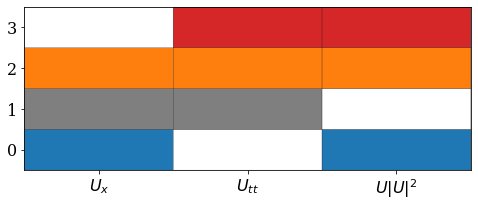

In [42]:
import seaborn as sns
from matplotlib.colors import ListedColormap
sns_list = sns.color_palette(n_colors=10)
sns_list.insert(0, '#ffffff')
sns_list.insert(1, '#1f77b4')
sns_list.insert(2, '#7f7f7f')
sns_list.insert(3, '#ff7f0e')
sns_list.insert(4, '#d62728')
sns_cmap = ListedColormap(sns_list)
cm = sns_cmap

balance_models = np.asarray([[1,0,1],[1,1,0],[1,1,1],[0,1,1]])
nmodels = 4 # number of candidate dominant balance models 
gridmap = balance_models.copy()
gridmap = (gridmap.T*np.arange(nmodels)).T
gridmap = (balance_models.T*np.arange(1, nmodels+1)).T

# Note that here we include the candidate model representing the dominant balance between
# the second-order dispersion and Kerr nonlinearity, however, this model is never identified
# by the algorihm to represent any local dynamics.

#Plot the candidate dominant balance models using a specific color code
plt.figure(figsize=(8, 3))
plt.pcolor(gridmap, vmin=-0.5, vmax=cm.N-0.5, cmap=cm, edgecolors='k')
plt.gca().set_xticks(np.arange(0.5, nfeatures+0.5))
plt.gca().set_xticklabels(labels, fontsize=16)
plt.gca().set_yticks(np.arange(0.5, nmodels+0.5))
plt.gca().set_yticklabels(range(0, nmodels), fontsize=16)
plt.show()

# Initializing the cluster colormap
clustermap = np.zeros([len(x)*len(f)])
clustermap[mask.flatten('F')] = cluster_idx+1  # Index into unmasked regions
clustermap = np.reshape(clustermap, [len(x), len(f)], order='F')

### 3. Dominant balance identification via combinatorial model selection algorithm

cluster # 1 of 8
cluster # 2 of 8
cluster # 3 of 8
cluster # 4 of 8
cluster # 5 of 8
cluster # 6 of 8
cluster # 7 of 8
cluster # 8 of 8


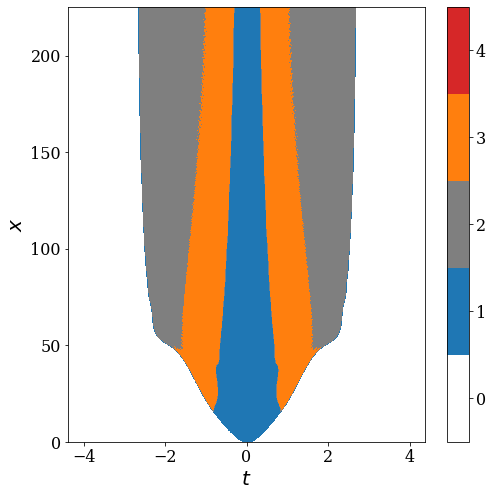

AVERAGED M SCORE = 0.8098200926999789


In [43]:
# Please note that the code below is not optimised and is used as an illustration.

x_step = 10 # step with respect to x in the model identification procedure
balancemap = np.empty_like(clustermap)
M_SEL = []

for cluster_ind in range(1, nc+1, 1):
    print('cluster #', cluster_ind, 'of', nc)
    CLUSTERMAP = clustermap * 0
    for i in range(len(f)):
        for j in range(len(x)):
            if clustermap[j,i] == cluster_ind:
                CLUSTERMAP[j,i] = cluster_ind
            else:
                CLUSTERMAP[j,i] = 0

    MAP2D = []
    MGN2D = []
    M_NLSE = []
    M_DISP = []
    M_NONL = []
    M_LAST = []

    for ind in range(0, len(x), x_step): # scan through x
        MAP1D = []
        MGN = []
        map1d = np.zeros(len(t))
        mgn1d = np.zeros(len(t))

        MGN1 = []
        SIGMA1 = []
        GN1 = []

        MGN2 = []
        SIGMA2 = []
        GN2 = []

        MGN3 = []
        SIGMA3 = []
        GN3 = []

        MGN4 = []
        SIGMA4 = []
        GN4 = []

        cc = np.where(clustermap[ind, :]==cluster_ind)
        if np.shape(cc)[1] == 0:
            continue

        #Constructing the corresponding normalised equation space matix at given x
        M1 =  np.vstack([np.sqrt(features_full[ind,cc, 0]**2 + features_full[ind,cc, 3]**2).flatten(), 
                        np.sqrt(features_full[ind,cc, 1]**2 + features_full[ind,cc, 4]**2).flatten(), 
                        np.sqrt(features_full[ind,cc, 2]**2 + features_full[ind,cc, 5]**2).flatten()])
        M = M1 / M1.min(axis=0)
        l = np.shape(M)[1]

        for i in range(l):
            #FULL DB
            gn = 1
            sigma = np.log10(max(M[:,i])) - np.log10(min(M[:,i]))
            mgn1 = gn / (1 + sigma)
            MGN1 = np.append(MGN1, mgn1)
            SIGMA1 = np.append(SIGMA1, sigma)
            GN1 = np.append(GN1, gn)

            #DISP DB
            if min(M[0:2:1,i]) - M[2,i] < 1:
                gn = 0
            else:
                gn = np.log10(min(M[0:2:1,i])-M[2,i])/np.log10(min(M[0:2:1,i])+M[2,i])
            sigma = np.log10(max(M[0:2,i]))-np.log10(min(M[0:2,i]))
            sigma = np.log10(max(M1[0:2,i]))-np.log10(min(M1[0:2,i]))
            mgn2 = gn / (1 + sigma)
            MGN2 =  np.append(MGN2, mgn2)
            SIGMA2 = np.append(SIGMA2, sigma)
            GN2 = np.append(GN2, gn)

            #NONL DB
            if min(M[0:3:2,i]) - M[1,i] < 1:
                gn = 0
            else:
                gn = np.log10(min(M[0:3:2,i]) - M[1,i]) / np.log10(min(M[0:3:2,i]) + M[1,i])
            sigma = np.log10(max(M[0:3:2,i])) - np.log10(min(M[0:3:2,i]))
            mgn3 = gn / (1 + sigma)
            MGN3 =  np.append(MGN3, mgn3)
            SIGMA3 = np.append(SIGMA3, sigma)
            GN3 = np.append(GN3, gn)

            #LAST DB
            if min(M[1:3:1,i]) - M[0,i] < 1:
                gn = 0
            else:
                 gn = np.log10(min(M[1:3:1,i]) - M[0,i]) / np.log10(min(M[1:3:1,i]) + M[0,i])
            sigma = np.log10(max(M[1:3:1,i])) - np.log10(min(M[1:3:1,i]))
            mgn4 = gn / (1 + sigma)
            MGN4 =  np.append(MGN4, mgn4)
            SIGMA4 = np.append(SIGMA4, sigma)
            GN4 = np.append(GN4, gn)

            if mgn1 > mgn2 and mgn1 > mgn3 and mgn1 > mgn4:
                MAP1D = np.append(MAP1D, 3)
                MGN = np.append(MGN, mgn1)

            if mgn2 > mgn1 and mgn2 > mgn3 and mgn2 > mgn4:
                MAP1D = np.append(MAP1D, 2)
                MGN = np.append(MGN, mgn2)

            if mgn3 > mgn1 and mgn3 > mgn2 and mgn3 > mgn4:
                MAP1D = np.append(MAP1D, 1)
                MGN = np.append(MGN, mgn3)

            if mgn4 > mgn1 and mgn4 > mgn2 and mgn4 > mgn3:
                MAP1D = np.append(MAP1D, 4)
                MGN = np.append(MGN, mgn4)

        M_NLSE = np.append(M_NLSE, MGN1)
        M_DISP = np.append(M_DISP, MGN2)
        M_NONL = np.append(M_NONL, MGN3)
        M_LAST = np.append(M_LAST, MGN4)
        
        map1d[cc] = MAP1D
        mgn1d[cc] = MGN
        MAP2D = np.append(MAP2D, map1d)
        MGN2D = np.append(MGN2D, mgn1d)
        
    n_total = len(M_NLSE)
    SCORE_NLSE = np.sum(M_NLSE) / n_total
    SCORE_DISP = np.sum(M_DISP) / n_total
    SCORE_NONL = np.sum(M_NONL) / n_total
    SCORE_LAST = np.sum(M_LAST) / n_total
    SCORE_BEST = np.sum(MGN2D[np.nonzero(MGN2D)])/len(MGN2D[np.nonzero(MGN2D)])

    if SCORE_NLSE >= SCORE_DISP and SCORE_NLSE >= SCORE_NONL and SCORE_NLSE >= SCORE_LAST:
        M_SEL = np.append(M_SEL, M_NLSE)
        MASK = (clustermap == cluster_ind)
        balancemap[MASK] = 3

    if SCORE_DISP > SCORE_NLSE and SCORE_DISP >= SCORE_NONL and SCORE_DISP >= SCORE_LAST:
        M_SEL = np.append(M_SEL, M_DISP)
        MASK = (clustermap == cluster_ind)
        balancemap[MASK] = 2

    if SCORE_NONL > SCORE_NLSE and SCORE_NONL > SCORE_DISP and SCORE_NONL >= SCORE_LAST:
        M_SEL = np.append(M_SEL, M_NONL)
        MASK = (clustermap == cluster_ind)
        balancemap[MASK] = 1

    if SCORE_LAST > SCORE_NLSE and SCORE_LAST > SCORE_DISP and SCORE_LAST > SCORE_NONL:
        M_SEL = np.append(M_SEL, M_LAST)
        MASK = (clustermap == cluster_ind)
        balancemap[MASK] = 4
    
# # Display only a central region of the spatio-spectral domain, where the spectral intensity is sufficiently non-zero
# start_index = int(3 * len(t) / 8)
# end_index = int(5 * len(t) / 8)
# data_slice = balancemap[:, start_index:end_index]
# t_slice = t[start_index:end_index]
# T, X = np.meshgrid(t_slice, x)

# plt.figure(figsize=(8, 8))
# plt.pcolor(T, X, data_slice, cmap=cm, vmin=-0.5, vmax=cm.N - 0.5, shading='auto')
# plt.xlabel('$\\nu$')
# plt.ylabel('$x$')
# plt.colorbar(boundaries=np.arange(-0.5, 5.5), ticks=np.arange(0, 5))
# plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(balancemap[:, int(3 * len(f) / 8):int(5 * len(f) / 8)], cmap=cm, vmin=-0.5, vmax=cm.N-0.5, origin='lower',
          extent=[min(t[int(3 * len(f) / 8):int(5 * len(f) / 8)]), max(t[int(3 * len(f) / 8):int(5 * len(f) / 8)]), min(x), max(x)], aspect='auto'); 
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.colorbar(boundaries=np.arange(-0.5, 5.5), ticks=np.arange(0, 5))
plt.show()

print('AVERAGED M SCORE =', np.sum(M_SEL) / len(M_SEL))

### 4. Display the identified local dominant balance models in the spatio-spectral domain

c:\users\ermol\pysindy-master\examples\venv\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  
c:\users\ermol\pysindy-master\examples\venv\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log10


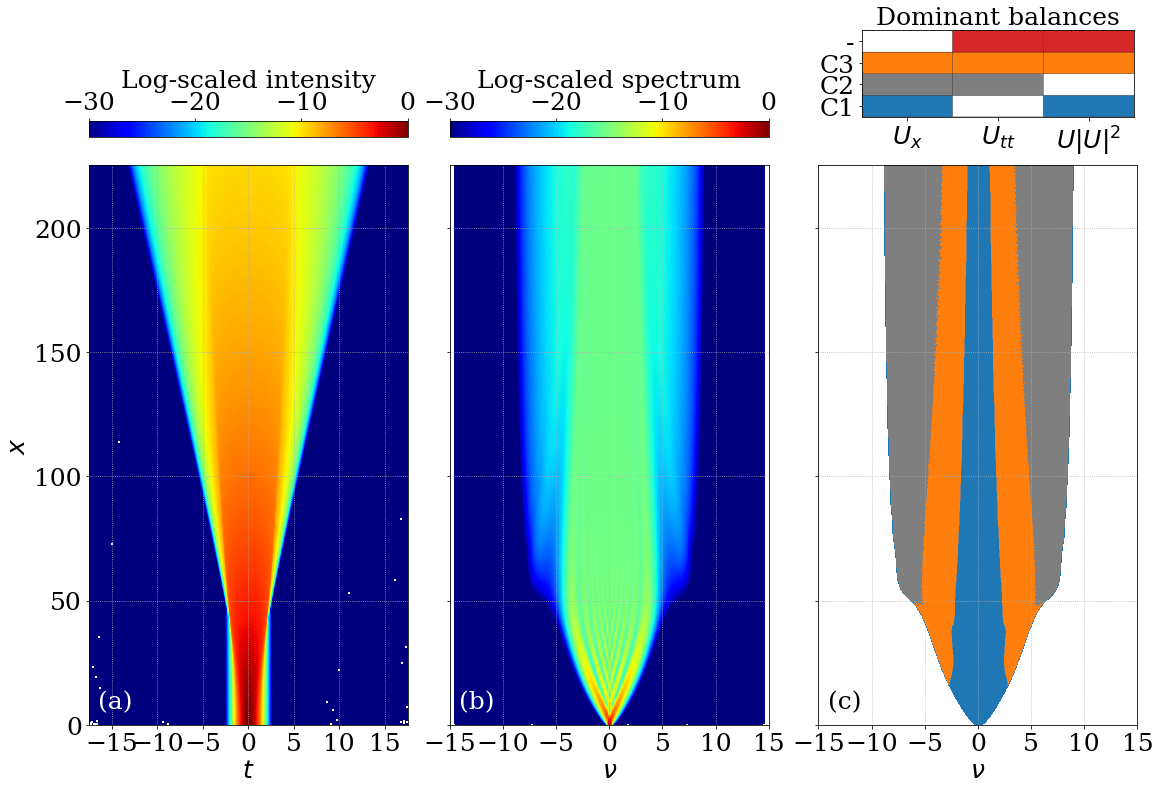

In [46]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.patches as patches

Sbalancemap = balancemap
edge = int(3 * len(f) / 8)
fs = 25

outer = [['long left', 'long center', 'long right'],
         ['long left', 'long center', 'long right']]

fig, axd = plt.subplot_mosaic(outer, layout="constrained")
fig.tight_layout
fig.set_figheight(10)
fig.set_figwidth(16)

it = lambda field: 10*np.log10(abs(field)**2) 

lIT = it(u); # log scale temporal intensity
mlIT = max(lIT.flatten())     # max value, for scaling plot
im1 = axd['long left'].imshow(lIT, cmap=colc, origin='lower', vmin=mlIT - TRS, vmax=mlIT,
          extent=[min(t), max(t), min(x), max(x)], aspect='auto'); 
axd['long left'].set_ylabel('$x$', fontsize=fs)
axd['long left'].set_xlabel('$t$', fontsize=fs)
axd['long left'].tick_params(axis = 'both', labelsize=fs)
axd['long left'].grid('True', linestyle = ':')
axd['long left'].set_xticks([-15,-10,-5,0,5,10,15])
cb = fig.colorbar(im1, ax = axd['long left'], location = 'top')
cb.ax.tick_params(labelsize=fs)
cb.set_label(label = 'Log-scaled intensity', size=fs)


it1 = lambda field: 10*np.log10(abs(field)**2) 
lIT = it1(s); # log scale temporal intensity
mlIT = max(lIT.flatten())     # max value, for scaling plot
im3 = axd['long center'].imshow(lIT[:, edge:len(t)-edge], cmap=colc, origin='lower', vmin=mlIT - 30, vmax=mlIT,
          extent=[min(f[edge:len(t)-edge]), max(f[edge:len(t)-edge]), min(x), max(x)], aspect='auto')          # plot as pseudocolor map
axd['long center'].grid('True', linestyle = ':')
axd['long center'].tick_params(labelleft= False)
axd['long center'].set_xlabel('$\\nu$', fontsize=fs)
axd['long center'].tick_params(labelleft= False)
axd['long center'].tick_params(axis = 'both', labelsize=fs)
axd['long center'].set_xticks([-15,-10,-5,0,5,10,15])
cb = fig.colorbar(im3, ax = axd['long center'], location = 'top')
cb.ax.tick_params(labelsize=fs)
cb.set_label(label = 'Log-scaled spectrum', size=fs)

# start_index = edge
# end_index = len(t) - edge
# data_slice = Sbalancemap[:, start_index:end_index]
# f_slice = f[start_index:end_index]
# F, X = np.meshgrid(f_slice, x)
# im2 = axd['long right'].pcolor(F, X, data_slice, cmap=cm, vmin=-0.5, vmax=cm.N - 0.5, shading='auto')
# axd['long right'].grid(True, linestyle=':')
# axd['long right'].set_xlabel('$\\nu$', fontsize=fs)
# axd['long right'].tick_params(labelleft=False, axis='both', labelsize=fs)
# axd['long right'].set_xticks([-15,-10,-5,0,5,10,15])

im2 = axd['long right'].imshow(Sbalancemap[:, edge:len(t)-edge], cmap=cm, vmin=-0.5, vmax=cm.N-0.5, origin='lower',
          extent=[min(f[edge:len(t)-edge]), max(f[edge:len(t)-edge]), min(x), max(x)], aspect='auto'); 
axd['long right'].grid('True', linestyle = ':')
axd['long right'].set_xlabel('$\\nu$', fontsize=fs)
axd['long right'].tick_params(labelleft= False)
rect = patches.Rectangle((-13, 60), 26, 4, linewidth=2, edgecolor='w', facecolor='none', linestyle = '--')
rect1 = patches.Rectangle((-6.75, 75.5), 4, 4, linewidth=2, edgecolor='w', facecolor='none', linestyle = '--')
axd['long right'].tick_params(axis = 'both', labelsize=fs)
axd['long right'].set_xticks([-15,-10,-5,0,5,10,15])



ax_ins = inset_axes(axd['long right'], width = '60%', height = 1.2, loc='upper left',
                   bbox_to_anchor=(0.12,1.2,1.425,0.05), bbox_transform=axd['long right'].transAxes)
plt.pcolor(gridmap, vmin=-0.5, vmax=cm.N-0.5, cmap=cm, edgecolors='k'); 
plt.title('Dominant balances', fontsize=fs)
plt.xticks([0.5, 1.5, 2.5], ['$U_{x}$','$U_{t t}$', '$U|U|^2$'], fontsize=fs)
plt.yticks([0.5,1.5, 2.5, 3.5], ['C1','C2','C3','-'], fontsize=fs)

axd['long left'].text(0.03, 0.03, '(a)', transform=axd['long left'].transAxes, size=fs, color = 'white')
axd['long center'].text(0.03, 0.03, '(b)', transform=axd['long center'].transAxes, size=fs, color = 'white')
axd['long right'].text(0.03, 0.03, '(c)', transform=axd['long right'].transAxes, size=fs, color = 'black')

plt.show()

# II Dominant balance analysis in spatio-temporal domain

### 1. Constructing the equation space matrix

In [19]:
nfeatures = 3 # features
featuremap = np.zeros([len(x), len(t), nfeatures], dtype='complex64');
featuremap[:, :, -3] = ux
featuremap[:, :, -2] = utt
featuremap[:, :, -1] = uuu

labels = ['$u_{x}$', '$u_{tt}$', '$u|u|^{2}$']

# Downsample for building model (optional, default - no downsampling)
shift_x, shift_t = 1, 1
tmin = 0
x0 = np.arange(0, len(x), shift_x)
t0 = np.arange(tmin, len(t), shift_t)
featuremap = featuremap[x0, :, :]
featuremap = featuremap[:, t0, :]

# Treshold the near-zero intensity values
lIT = it(u)
lIT = lIT[x0, :]
lIT = lIT[:, t0]
mlIT = max(lIT.flatten())
mask = lIT > mlIT - TRS

features = np.reshape(featuremap, [len(x0)*len(t0), nfeatures], order='F')
features = features[mask.flatten('F'), :]
features = np.hstack((np.real(features), np.imag(features)))

c:\users\ermol\pysindy-master\examples\venv\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  


### 2. Visualising the dynamical patterns in the equation space

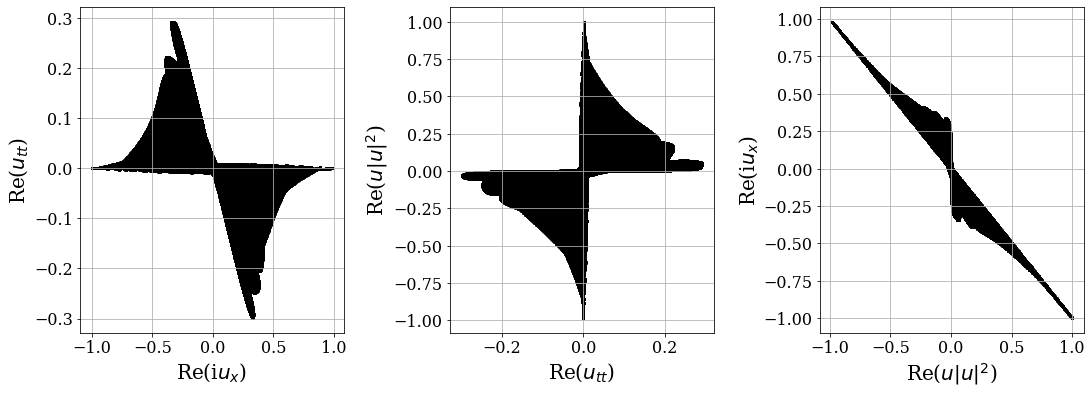

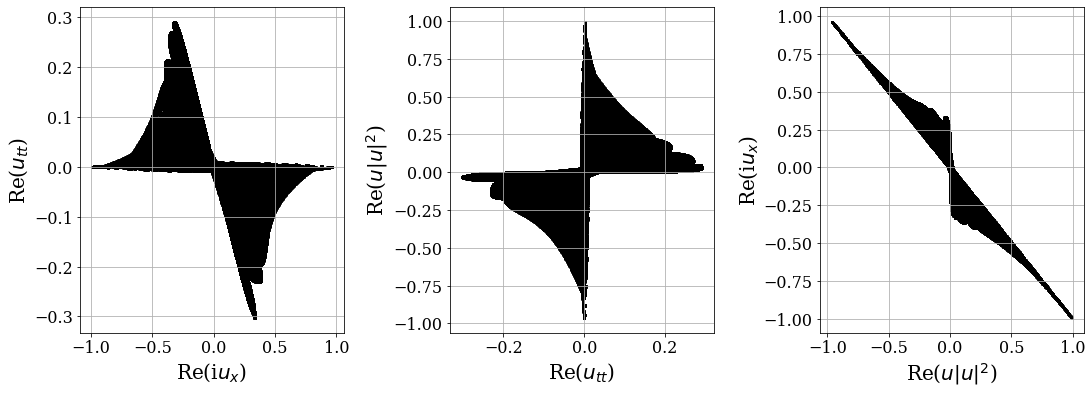

In [20]:
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.scatter(features[:, 0], features[:, 1], 3, 'k')
plt.xlabel(f'Re(i{labels[0]})')
plt.ylabel(f'Re({labels[1]})')
plt.grid()

plt.subplot(132)
plt.scatter(features[:, 1], features[:, 2], 3, 'k')
plt.xlabel(f'Re({labels[1]})')
plt.ylabel(f'Re({labels[2]})')
plt.grid()

plt.subplot(133)
plt.scatter(features[:, 2], features[:, 0], 3, 'k')
plt.xlabel(f'Re({labels[2]})')
plt.ylabel(f'Re(i{labels[0]})')
plt.grid()

plt.subplots_adjust(wspace=0.4)  # Adjust the space between plots
plt.show()

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.scatter(features[:, 3], features[:, 4], 3, 'k')
plt.xlabel(f'Re(i{labels[0]})')
plt.ylabel(f'Re({labels[1]})')
plt.grid()

plt.subplot(132)
plt.scatter(features[:, 4], features[:, 5], 3, 'k')
plt.xlabel(f'Re({labels[1]})')
plt.ylabel(f'Re({labels[2]})')
plt.grid()

plt.subplot(133)
plt.scatter(features[:, 5], features[:, 3], 3, 'k')
plt.xlabel(f'Re({labels[2]})')
plt.ylabel(f'Re(i{labels[0]})')
plt.grid()

plt.subplots_adjust(wspace=0.4)
plt.show()

### 3. GMM clustering

In [21]:
# Note that a sufficiently large number of GMM clusters are chosen here to illustrate 
# how the algorithm is adapted for the case of redundant clusters
# training GMM model may take some time
nc = 15
seed = 102230
model = GaussianMixture(n_components=nc, random_state=seed)
model.fit(features)

GaussianMixture(n_components=15, random_state=102230)

### 4. Recomputing for the full domain (if needed) 

In [22]:
nfeatures = 3 # features
featuremap = np.zeros([len(x), len(t), nfeatures], dtype='complex64');

featuremap[:, :, -3] = ux
featuremap[:, :, -2] = utt
featuremap[:, :, -1] = uuu

labels = ['$iu_{x}$', '$u_{tt}$', '$u|u|^{2}$']

tmin = 0

t0 = np.arange(tmin, len(t))
featuremap = featuremap[:, t0, :];

lIT = it(u)
lIT = lIT[:, t0]
mlIT = max(lIT.flatten())
mask = lIT > mlIT-TRS

features = np.reshape(featuremap, [len(x)*len(t0), nfeatures], order='F');
features = features[mask.flatten('F'), :]

features = np.hstack((np.real(features), np.imag(features))) 
# Cluster domain based on previously trained GMM
cluster_idx = model.predict(features)
print(np.shape(features))

c:\users\ermol\pysindy-master\examples\venv\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  


(1568350, 6)


## Dominant balance identification via combinatorial model selection algorithm 

### 1. Building the full feature matrix in spatio-temporal domain

In [23]:
nfeatures = 3 # features
featuremap = np.zeros([len(x), len(t), nfeatures], dtype='complex64');

featuremap[:, :, -3] = ux
featuremap[:, :, -2] = utt
featuremap[:, :, -1] = uuu

features_full = np.dstack((np.real(featuremap), np.imag(featuremap)))
print(np.shape(features_full))

(1000, 4096, 6)


### 2. Initializing candidate dominant balance models

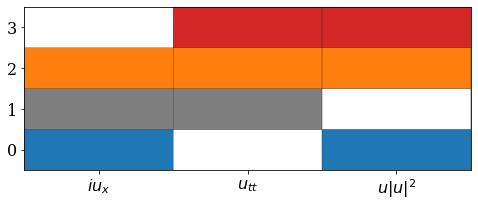

In [24]:
### 2. Evaluate the best possible DB and display itimport matplotlib.cm as cm

# Seaborn colormap
import seaborn as sns
from matplotlib.colors import ListedColormap
sns_list = sns.color_palette(n_colors=10)
sns_list.insert(0, '#ffffff')  # Insert white at zero position
sns_list.insert(1, '#1f77b4')  # Insert white at zero position
sns_list.insert(2, '#7f7f7f')  # Insert white at zero position
sns_list.insert(3, '#ff7f0e')  # Insert white at zero position
sns_list.insert(4, '#d62728')  # Insert white at zero position

sns_cmap = ListedColormap(sns_list)
cm = sns_cmap

balance_models = np.asarray([[1,0,1],[1,1,0],[1,1,1],[0,1,1]])
nmodels = 4
gridmap = balance_models.copy()
gridmap = (gridmap.T*np.arange(nmodels)).T  # Scale map so that active terms can be color-coded

gridmap = (balance_models.T*np.arange(1, nmodels+1)).T

plt.figure(figsize=(8, 3))
plt.pcolor(gridmap, vmin=-0.5, vmax=cm.N-0.5, cmap=cm, edgecolors='k')
plt.gca().set_xticks(np.arange(0.5, nfeatures+0.5))
plt.gca().set_xticklabels(labels, fontsize=16)
plt.gca().set_yticks(np.arange(0.5, nmodels+0.5))
plt.gca().set_yticklabels(range(0, nmodels), fontsize=16)
plt.show()

# Colormap of clusters
clustermap = np.zeros([len(x)*len(t0)])
clustermap[mask.flatten('F')] = cluster_idx+1  # Index into unmasked regions
clustermap = np.reshape(clustermap, [len(x), len(t0)], order='F')

### 3. Dominant balance identification via combinatorial model selection algorithm

cluster # 1 of 15
cluster # 2 of 15
cluster # 3 of 15
cluster # 4 of 15
cluster # 5 of 15
cluster # 6 of 15
cluster # 7 of 15
cluster # 8 of 15
cluster # 9 of 15
cluster # 10 of 15
cluster # 11 of 15
cluster # 12 of 15
cluster # 13 of 15
cluster # 14 of 15
cluster # 15 of 15


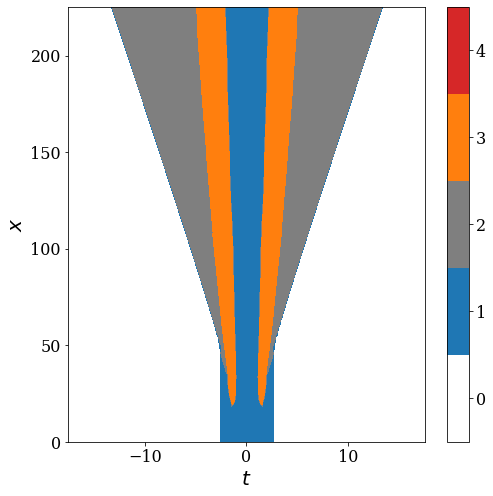

AVERAGED M SCORE = 0.814195633944434


In [25]:
# Please note that the code below is not optimised and is used as an illustration.

x_step = 10 # step with respect to x in the model identification procedure
balancemap = np.empty_like(clustermap)
M_SEL = []

for cluster_ind in range(1, nc+1, 1):
    print('cluster #', cluster_ind, 'of', nc)
    CLUSTERMAP = clustermap * 0
    for i in range(len(f)):
        for j in range(len(x)):
            if clustermap[j,i] == cluster_ind:
                CLUSTERMAP[j,i] = cluster_ind
            else:
                CLUSTERMAP[j,i] = 0

    MAP2D = []
    MGN2D = []
    M_NLSE = []
    M_DISP = []
    M_NONL = []
    M_LAST = []

    for ind in range(0, len(x), x_step): # scan through x
        MAP1D = []
        MGN = []
        map1d = np.zeros(len(t))
        mgn1d = np.zeros(len(t))

        MGN1 = []
        SIGMA1 = []
        GN1 = []

        MGN2 = []
        SIGMA2 = []
        GN2 = []

        MGN3 = []
        SIGMA3 = []
        GN3 = []

        MGN4 = []
        SIGMA4 = []
        GN4 = []

        cc = np.where(clustermap[ind, :]==cluster_ind)
        if np.shape(cc)[1] == 0:
            continue

        #Constructing the corresponding normalised equation space matix at given x
        M1 =  np.vstack([np.sqrt(features_full[ind,cc, 0]**2 + features_full[ind,cc, 3]**2).flatten(), 
                        np.sqrt(features_full[ind,cc, 1]**2 + features_full[ind,cc, 4]**2).flatten(), 
                        np.sqrt(features_full[ind,cc, 2]**2 + features_full[ind,cc, 5]**2).flatten()])
        M = M1 / M1.min(axis=0)
        l = np.shape(M)[1]

        for i in range(l):
            #FULL DB
            gn = 1
            sigma = np.log10(max(M[:,i])) - np.log10(min(M[:,i]))
            mgn1 = gn / (1 + sigma)
            MGN1 = np.append(MGN1, mgn1)
            SIGMA1 = np.append(SIGMA1, sigma)
            GN1 = np.append(GN1, gn)

            #DISP DB
            if min(M[0:2:1,i]) - M[2,i] < 1:
                gn = 0
            else:
                gn = np.log10(min(M[0:2:1,i])-M[2,i])/np.log10(min(M[0:2:1,i])+M[2,i])
            sigma = np.log10(max(M[0:2,i]))-np.log10(min(M[0:2,i]))
            sigma = np.log10(max(M1[0:2,i]))-np.log10(min(M1[0:2,i]))
            mgn2 = gn / (1 + sigma)
            MGN2 =  np.append(MGN2, mgn2)
            SIGMA2 = np.append(SIGMA2, sigma)
            GN2 = np.append(GN2, gn)

            #NONL DB
            if min(M[0:3:2,i]) - M[1,i] < 1:
                gn = 0
            else:
                gn = np.log10(min(M[0:3:2,i]) - M[1,i]) / np.log10(min(M[0:3:2,i]) + M[1,i])
            sigma = np.log10(max(M[0:3:2,i])) - np.log10(min(M[0:3:2,i]))
            mgn3 = gn / (1 + sigma)
            MGN3 =  np.append(MGN3, mgn3)
            SIGMA3 = np.append(SIGMA3, sigma)
            GN3 = np.append(GN3, gn)

            #LAST DB
            if min(M[1:3:1,i]) - M[0,i] < 1:
                gn = 0
            else:
                 gn = np.log10(min(M[1:3:1,i]) - M[0,i]) / np.log10(min(M[1:3:1,i]) + M[0,i])
            sigma = np.log10(max(M[1:3:1,i])) - np.log10(min(M[1:3:1,i]))
            mgn4 = gn / (1 + sigma)
            MGN4 =  np.append(MGN4, mgn4)
            SIGMA4 = np.append(SIGMA4, sigma)
            GN4 = np.append(GN4, gn)

            if mgn1 > mgn2 and mgn1 > mgn3 and mgn1 > mgn4:
                MAP1D = np.append(MAP1D, 3)
                MGN = np.append(MGN, mgn1)

            if mgn2 > mgn1 and mgn2 > mgn3 and mgn2 > mgn4:
                MAP1D = np.append(MAP1D, 2)
                MGN = np.append(MGN, mgn2)

            if mgn3 > mgn1 and mgn3 > mgn2 and mgn3 > mgn4:
                MAP1D = np.append(MAP1D, 1)
                MGN = np.append(MGN, mgn3)

            if mgn4 > mgn1 and mgn4 > mgn2 and mgn4 > mgn3:
                MAP1D = np.append(MAP1D, 4)
                MGN = np.append(MGN, mgn4)

        M_NLSE = np.append(M_NLSE, MGN1)
        M_DISP = np.append(M_DISP, MGN2)
        M_NONL = np.append(M_NONL, MGN3)
        M_LAST = np.append(M_LAST, MGN4)
        
        map1d[cc] = MAP1D
        mgn1d[cc] = MGN
        MAP2D = np.append(MAP2D, map1d)
        MGN2D = np.append(MGN2D, mgn1d)
        
    n_total = len(M_NLSE)
    SCORE_NLSE = np.sum(M_NLSE) / n_total
    SCORE_DISP = np.sum(M_DISP) / n_total
    SCORE_NONL = np.sum(M_NONL) / n_total
    SCORE_LAST = np.sum(M_LAST) / n_total
    SCORE_BEST = np.sum(MGN2D[np.nonzero(MGN2D)])/len(MGN2D[np.nonzero(MGN2D)])

    if SCORE_NLSE >= SCORE_DISP and SCORE_NLSE >= SCORE_NONL and SCORE_NLSE >= SCORE_LAST:
        M_SEL = np.append(M_SEL, M_NLSE)
        MASK = (clustermap == cluster_ind)
        balancemap[MASK] = 3

    if SCORE_DISP > SCORE_NLSE and SCORE_DISP >= SCORE_NONL and SCORE_DISP >= SCORE_LAST:
        M_SEL = np.append(M_SEL, M_DISP)
        MASK = (clustermap == cluster_ind)
        balancemap[MASK] = 2

    if SCORE_NONL > SCORE_NLSE and SCORE_NONL > SCORE_DISP and SCORE_NONL >= SCORE_LAST:
        M_SEL = np.append(M_SEL, M_NONL)
        MASK = (clustermap == cluster_ind)
        balancemap[MASK] = 1

    if SCORE_LAST > SCORE_NLSE and SCORE_LAST > SCORE_DISP and SCORE_LAST > SCORE_NONL:
        M_SEL = np.append(M_SEL, M_LAST)
        MASK = (clustermap == cluster_ind)
        balancemap[MASK] = 4
    
plt.figure(figsize=(8, 8))
plt.imshow(balancemap, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, origin='lower',
          extent=[min(t), max(t), min(x), max(x)], aspect='auto'); 
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.colorbar(boundaries=np.arange(-0.5, 5.5), ticks=np.arange(0, 5))
plt.show()
print('AVERAGED M SCORE =', np.sum(M_SEL) / len(M_SEL))

### 4. Display the identified local dominant balance models in the spatio-temporal domain

c:\users\ermol\pysindy-master\examples\venv\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
c:\users\ermol\pysindy-master\examples\venv\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10


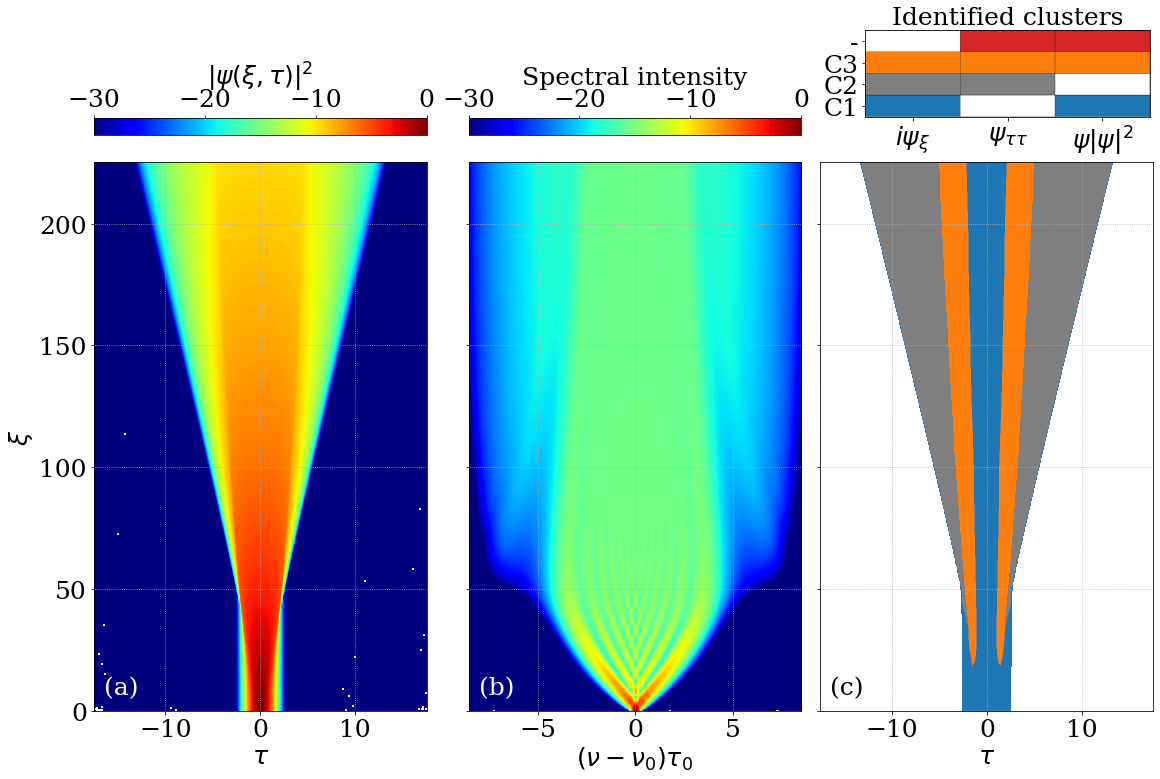

In [26]:
edge = 0
fs = 25

from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.patches as patches

    

outer = [['long left', 'long center', 'long right'],
         ['long left', 'long center', 'long right']]

fig, axd = plt.subplot_mosaic(outer, layout="constrained")
fig.tight_layout
fig.set_figheight(10)
fig.set_figwidth(16)


it = lambda field: 10*np.log10(abs(field)**2) 

lIT = it(u); # log scale temporal intensity
mlIT = max(lIT.flatten())     # max value, for scaling plot
im1 = axd['long left'].imshow(lIT[:,edge:len(t)-edge], cmap=colc, origin='lower', vmin=mlIT - TRS, vmax=mlIT,
          extent=[min(t[edge:len(t)-edge]), max(t[edge:len(t)-edge]), min(x), max(x)], aspect='auto'); 
axd['long left'].set_ylabel('$\u03BE$', fontsize=fs)
axd['long left'].set_xlabel('$\u03C4$', fontsize=fs)
axd['long left'].tick_params(axis = 'both', labelsize=fs)

axd['long left'].grid('True', linestyle = ':')
cb = fig.colorbar(im1, ax = axd['long left'], location = 'top')
cb.ax.tick_params(labelsize=fs)
cb.set_label(label = '$|\u03C8(\u03BE,\u03C4)|^2$', size=fs)


it1 = lambda field: 10*np.log10(abs(field)**2) 
lIT = it1(s); # log scale temporal intensity
mlIT = max(lIT.flatten())     # max value, for scaling plot
im3 = axd['long center'].imshow(lIT[:, 1748:2348], cmap=colc, origin='lower', vmin=mlIT - 30, vmax=mlIT,
          extent=[min(f[1748:2348]), max(f[1748:2348]), min(x), max(x)], aspect='auto')          # plot as pseudocolor map
# axd['long right'].set_xlim(frange);
axd['long center'].grid('True', linestyle = ':')
axd['long center'].tick_params(labelleft= False)
axd['long center'].set_xlabel('$(\u03BD - \u03BD_{0})\u03C4_{0}$', fontsize=fs)
axd['long center'].tick_params(labelleft= False)
axd['long center'].tick_params(axis = 'both', labelsize=fs)
cb = fig.colorbar(im3, ax = axd['long center'], location = 'top')
cb.ax.tick_params(labelsize=fs)
cb.set_label(label = 'Spectral intensity', size=fs)


im2 = axd['long right'].imshow(balancemap[:,edge:len(t)-edge], cmap=cm, vmin=-0.5, vmax=cm.N-0.5, origin='lower',
          extent=[min(t[edge:len(t)-edge]), max(t[edge:len(t)-edge]), min(x), max(x)], aspect='auto'); 
axd['long right'].grid('True', linestyle = ':')
axd['long right'].set_xlabel('$\u03C4$', fontsize=fs)
axd['long right'].tick_params(labelleft= False)
rect = patches.Rectangle((-13, 60), 26, 4, linewidth=2, edgecolor='w', facecolor='none', linestyle = '--')
rect1 = patches.Rectangle((-6.75, 75.5), 4, 4, linewidth=2, edgecolor='w', facecolor='none', linestyle = '--')
axd['long right'].tick_params(axis = 'both', labelsize=fs)



ax_ins = inset_axes(axd['long right'], width = '60%', height = 1.2, loc='upper left',
                   bbox_to_anchor=(0.12,1.2,1.425,0.05), bbox_transform=axd['long right'].transAxes)
plt.pcolor(gridmap, vmin=-0.5, vmax=cm.N-0.5, cmap=cm, edgecolors='k'); 
plt.title('Identified clusters', fontsize=fs)
plt.xticks([0.5, 1.5, 2.5], ['$i \u03C8_{\u03BE}$','$\u03C8_{\u03C4 \u03C4}$', '$\u03C8|\u03C8|^2$'], fontsize=fs)
plt.yticks([0.5,1.5, 2.5, 3.5], ['C1','C2','C3','-'], fontsize=fs)

axd['long left'].text(0.03, 0.03, '(a)', transform=axd['long left'].transAxes, size=fs, color = 'white')
axd['long center'].text(0.03, 0.03, '(b)', transform=axd['long center'].transAxes, size=fs, color = 'white')
axd['long right'].text(0.03, 0.03, '(c)', transform=axd['long right'].transAxes, size=fs, color = 'black')

plt.show()

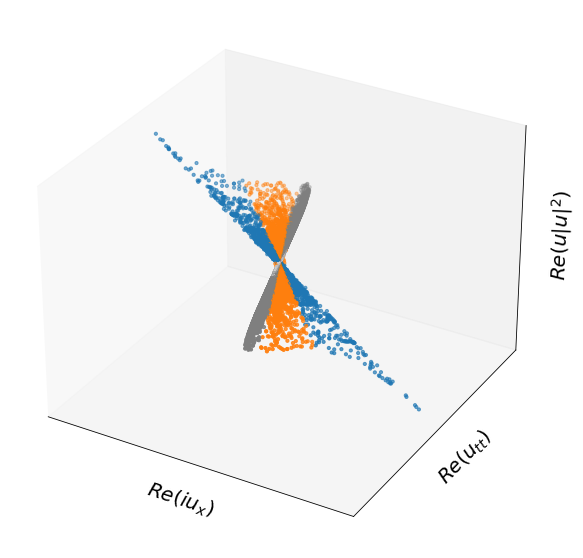

In [27]:
balance_idx = balancemap.flatten()
kk = 100
mu = []
MU = []
for i in range(0, int(len(balance_idx)/kk)):
    if balance_idx[kk * i]==0:
        mu = np.array([255, 255, 255])
    if balance_idx[kk * i]==1:
        mu = np.array([31, 119, 180])
    if balance_idx[kk * i]==2:
        mu = np.array([127, 127, 127])
    if balance_idx[kk * i]==3:
        mu = np.array([255, 127, 14])
    MU = np.append(MU,mu)
MU = np.reshape(MU, (int(len(MU)/3) , 3))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(features_full[:,:,0].flatten()[::kk], features_full[:,:,1].flatten()[::kk], features_full[:,:,2].flatten()[::kk], c=MU/255, s=10)
ax.set_xlabel('$Re(iu_x)$')
ax.set_ylabel('$Re(u_{tt})$')
ax.set_zlabel('$Re(u|u|^2)$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.grid(False)
plt.show()

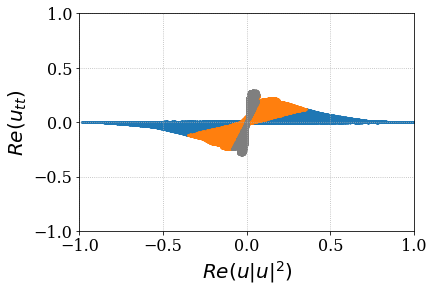

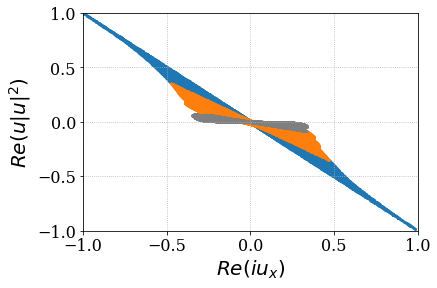

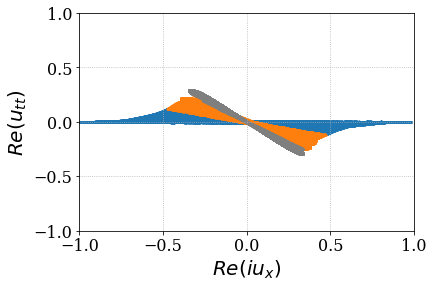

In [28]:
S = 1
k = 1
idx_1 = [k * i for i, val in enumerate(balance_idx[::k]) if val == 1]
idx_2 = [k * i for i, val in enumerate(balance_idx[::k]) if val == 2]
idx_3 = [k * i for i, val in enumerate(balance_idx[::k]) if val == 3]


plt.scatter(features_full[:,:,2].flatten()[idx_1], features_full[:,:,1].flatten()[idx_1], color = '#1f77b4', s = S)
plt.scatter(features_full[:,:,2].flatten()[idx_3], features_full[:,:,1].flatten()[idx_3], color = '#ff7f0e', s = S)
plt.scatter(features_full[:,:,2].flatten()[idx_2], features_full[:,:,1].flatten()[idx_2], color = '#7f7f7f', s = S)
plt.xlabel('$Re(u|u|^2)$')
plt.ylabel('$Re(u_{tt})$')
plt.grid('True', linestyle = ':')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

plt.scatter(features_full[:,:,0].flatten()[idx_1], features_full[:,:,2].flatten()[idx_1], color = '#1f77b4', s = S)
plt.scatter(features_full[:,:,0].flatten()[idx_3], features_full[:,:,2].flatten()[idx_3], color = '#ff7f0e', s = S)
plt.scatter(features_full[:,:,0].flatten()[idx_2], features_full[:,:,2].flatten()[idx_2], color = '#7f7f7f', s = S)
plt.xlabel('$Re(iu_{x})$')
plt.ylabel('$Re(u|u|^2)$')
plt.grid('True', linestyle = ':')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

plt.scatter(features_full[:,:,0].flatten()[idx_1], features_full[:,:,1].flatten()[idx_1], color = '#1f77b4', s = S)
plt.scatter(features_full[:,:,0].flatten()[idx_3], features_full[:,:,1].flatten()[idx_3], color = '#ff7f0e', s = S)
plt.scatter(features_full[:,:,0].flatten()[idx_2], features_full[:,:,1].flatten()[idx_2], color = '#7f7f7f', s = S)
plt.xlabel('$Re(iu_{x})$')
plt.ylabel('$Re(u_{tt})$')
plt.grid('True', linestyle = ':')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()